In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(123)

## Utility Functions

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# def generate_random_weighted_adj_matrix(size=5, max_weight=1):
#     # np.random.seed()  # For reproducibility
#     adj_matrix = np.zeros((size, size), dtype=int)
#     for i in range(size):
#         for j in range(i + 1, size):
#             weight = np.random.randint(1, max_weight + 1)
#             adj_matrix[i][j] = weight
#             adj_matrix[j][i] = weight  # Ensure the graph is undirected
#     return adj_matrix

def generate_random_weighted_adj_matrix(size=5, max_weight=1, edge_probability=0.5):
    global matrix
    np.random.seed()  # For reproducibility
    adj_matrix = np.zeros((size, size), dtype=int)

    for i in range(size):
        for j in range(i + 1, size):
            if np.random.rand() < edge_probability:
                weight = np.random.randint(1, max_weight + 1)
                adj_matrix[i][j] = weight
                adj_matrix[j][i] = weight

    matrix = adj_matrix

    return adj_matrix

def greedy_max_cut(adj_matrix):
    set_a = {0}
    set_b = set()
    for vertex in range(1, len(adj_matrix)):
        # This simplistic greedy algorithm does not consider weights for the decision
        if sum(adj_matrix[vertex][i] for i in set_a) > sum(adj_matrix[vertex][j] for j in set_b):
            set_b.add(vertex)
        else:
            set_a.add(vertex)
    return set_a, set_b

def get_cut_amount(adj_matrix,set_a,set_b):
  cut_amount = 0
  for v_a in set_a:
    cut_amount+=sum(adj_matrix[v_a][v_b] for v_b in set_b)
  return cut_amount

def draw_weighted_graph_with_highlighted_cut(adj_matrix, set_a, set_b,*,method='Greedy'):
    G = nx.Graph()
    cut = get_cut_amount(adj_matrix,set_a,set_b)
    for i in range(len(adj_matrix)):
        for j in range(i + 1, len(adj_matrix)):
            if adj_matrix[i][j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])

    np.random.seed(42)
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=list(set_a), node_color='skyblue', node_size=700, label="Set A")
    nx.draw_networkx_nodes(G, pos, nodelist=list(set_b), node_color='lightgreen', node_size=700, label="Set B")

    # Edges within sets
    intra_edges = [(u, v) for u, v in G.edges() if (u in set_a and v in set_a) or (u in set_b and v in set_b)]
    nx.draw_networkx_edges(G, pos, edgelist=intra_edges, width=2, alpha=0.5, edge_color='grey')

    # Highlighted edges between sets
    inter_edges = [(u, v) for u, v in G.edges() if (u in set_a and v in set_b) or (u in set_b and v in set_a)]
    nx.draw_networkx_edges(G, pos, edgelist=inter_edges, width=2, alpha=0.8, edge_color='red')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in inter_edges}, label_pos=0.3, font_color='red')

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.title(f"Graph with {method} Maximum Cut")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()

## Goemans-Williamson

In [ ]:
# def goemans_williamson_max_cut(adjacency_matrix, num_iterations=100):
#     n = len(adjacency_matrix)
#     best_cut_size = -1
#     best_partition = None

#     for _ in range(num_iterations):
#         # Generate a random vector of Gaussian distributed values
#         random_vector = np.random.normal(size=n)

#         # Normalize the vector
#         norm = np.linalg.norm(random_vector)
#         normalized_vector = random_vector / norm

#         # Assign vertices to sets based on the sign of the normalized vector
#         partition = [[], []]
#         for i in range(n):
#             partition[0 if normalized_vector[i] < 0 else 1].append(i)

#         # Compute the cut size
#         cut_size = sum(adjacency_matrix[i][j] for i in partition[0] for j in partition[1])

#         # Update the best cut found so far
#         if cut_size > best_cut_size:
#             best_cut_size = cut_size
#             best_partition = partition

#     return best_partition, best_cut_size

In [4]:
import cvxpy as cp
from scipy.linalg import sqrtm

def goemans_williamson_max_cut(adj,iter=10):
  k = adj.shape[0]

  edges = [(i,j,adj[i][j]) for i in range(k) for j in range(k)]

  X = cp.Variable((k,k),symmetric=True)
  constraints = [X >> 0]
  constraints+=[
      X[i,i] == 1 for i in range(k)
  ]
  objective = sum(0.5 *w*(1-X[i,j]) for (i,j,w) in edges)
  problem = cp.Problem(cp.Maximize(objective),constraints)
  problem.solve()

  x = sqrtm(X.value)

  max_cut = -1
  max_partition = None

  for i in range(iter):
    r = np.random.randn(k)
    p = np.real(np.sign(x @ r))
    partition = (np.where(p >= 0)[0], np.where(p < 0)[0])
    cut = np.sum(adj[partition[0], :][:, partition[1]])

    if cut > max_cut:
      max_partition = partition
      max_cut = cut
  return max_cut, max_partition

In [ ]:
# adj_matrix = np.array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,],
#  [1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,],
#  [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,],
#  [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,],
#  [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,],
#  [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,],
#  [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,],
#  [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,],
#  [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,],
#  [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,],
#  [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,],
#  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,],
#  [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,],
#  [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,],
#  [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,],
#  [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,],
#  [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,],
#  [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,],
#  [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,],
#  [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,]])

# adj_matrix = np.array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 0,],
#  [0, 0, 0, 1, 0, 1, 1, 1, 1, 0,],
#  [0, 0, 0, 0, 1, 0, 0, 1, 0, 1,],
#  [1, 1, 0, 0, 0, 1, 1, 1, 0, 1,],
#  [1, 0, 1, 0, 0, 1, 1, 0, 0, 1,],
#  [1, 1, 0, 1, 1, 0, 0, 0, 1, 1,],
#  [1, 1, 0, 1, 1, 0, 0, 1, 1, 1,],
#  [1, 1, 1, 1, 0, 0, 1, 0, 1, 0,],
#  [1, 1, 0, 0, 0, 1, 1, 1, 0, 1,],
#  [0, 0, 1, 1, 1, 1, 1, 0, 1, 0,]])

adj_matrix = np.array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0]])

# adj_matrix = [
#     [0, 0, 1, 1, 0, 0],
#     [0, 0, 1, 1, 0, 0],
#     [1, 1, 0, 0, 1, 1],
#     [1, 1, 0, 0, 1, 1],
#     [0, 0, 1, 1, 0, 0],
#     [0, 0, 1, 1, 0, 0]
# ]

In [8]:
N = 10
adj_matrix = generate_random_weighted_adj_matrix(N)

greed_set_a , greed_set_b = greedy_max_cut(adj_matrix)

cut_size, partition = goemans_williamson_max_cut(adj_matrix,1000)

total_edges = 0
for i in range(len(adj_matrix)):
  total_edges += len(adj_matrix[i])
print(f'Total edges: {total_edges // 2}')

print(f"---------------Greedy-----------------")
print(f"Set a: {greed_set_a} Set b: {greed_set_b} Cut: {get_cut_amount(adj_matrix,greed_set_a,greed_set_b)}")
print(f"--------------------------------------")
print(f"----------Goemans Williamson----------")
print(f"Set a: {partition[0]} Set b: {partition[1]} Cut: {cut_size}")
print(f"--------------------------------------")

Total edges: 20000
---------------Greedy-----------------
Set a: {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198} Set b: {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199} Cut: 10000
-------------------------

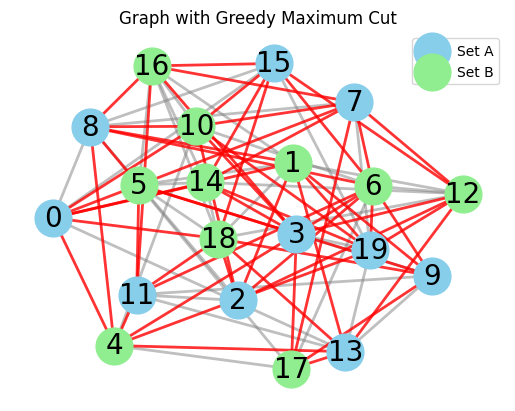

In [ ]:
draw_weighted_graph_with_highlighted_cut(adj_matrix,greed_set_a,greed_set_b,method='Greedy')

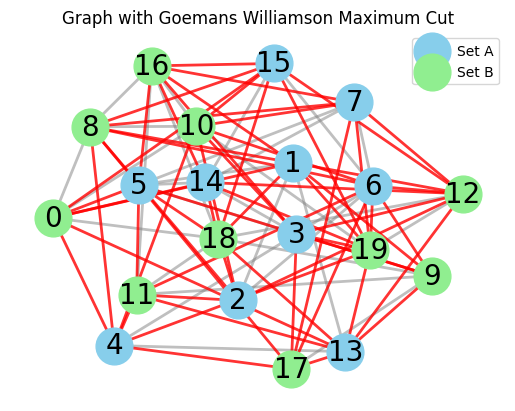

In [ ]:
draw_weighted_graph_with_highlighted_cut(adj_matrix,partition[0],partition[1],method='Goemans Williamson')

## Original Graph

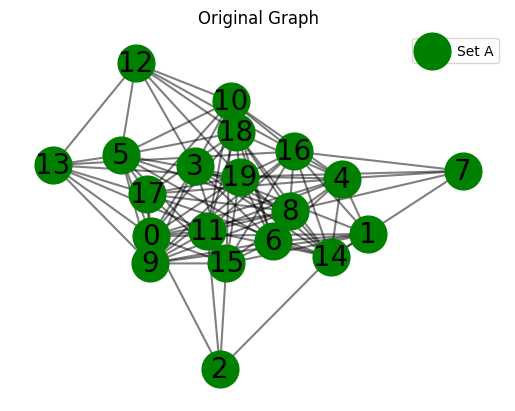

In [ ]:
def draw_original_graph(adj_matrix, set_a):
    G = nx.Graph()
    for i in range(len(adj_matrix)):
        for j in range(i + 1, len(adj_matrix)):
            if adj_matrix[i][j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])

    np.random.seed(42)
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=list(set_a), node_color='green', node_size=700, label="Set A")

    # Edges within sets
    intra_edges = [(u, v) for u, v in G.edges() if (u in set_a and v in set_a)]
    nx.draw_networkx_edges(G, pos, edgelist=intra_edges, width=1.5, alpha=0.5, edge_color='black')

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.title("Original Graph")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()

n = 20
set_a = set()
for i in range(N):
  set_a.add(i)
draw_original_graph(adj_matrix, set_a)

## Optimal Graph

In [ ]:
def brute_force_maximum_cut(adj_matrix):
    num_vertices = len(adj_matrix)
    max_cut_size = 0
    best_partition = None

    # Generate all possible partitions (2^n subsets)
    for mask in range(1 << num_vertices):
        set_a = set()
        set_b = set()

        for i in range(num_vertices):
            if mask & (1 << i):
                set_a.add(i)
            else:
                set_b.add(i)

        # Calculate the cut size (sum of weights of edges crossing the partition)
        cut_size = 0
        for u in set_a:
            for v in set_b:
                cut_size += adj_matrix[u][v]

        if cut_size > max_cut_size:
            max_cut_size = cut_size
            best_partition = (set_a, set_b)

    return max_cut_size, best_partition

def draw_optimal_cut(adj_matrix, set_a, set_b):
    G = nx.Graph()
    for i in range(len(adj_matrix)):
        for j in range(i + 1, len(adj_matrix)):
            if adj_matrix[i][j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])

    np.random.seed(42)
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=list(set_a), node_color='skyblue', node_size=700, label="Set A")
    nx.draw_networkx_nodes(G, pos, nodelist=list(set_b), node_color='lightgreen', node_size=700, label="Set B")

    # Edges within sets
    intra_edges = [(u, v) for u, v in G.edges() if (u in set_a and v in set_a) or (u in set_b and v in set_b)]
    nx.draw_networkx_edges(G, pos, edgelist=intra_edges, width=1.5, alpha=0.5, edge_color='grey')

    # Highlighted edges between sets
    inter_edges = [(u, v) for u, v in G.edges() if (u in set_a and v in set_b) or (u in set_b and v in set_a)]
    nx.draw_networkx_edges(G, pos, edgelist=inter_edges, width=1.5, alpha=0.5, edge_color='red')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G[u][v]['weight'] for u, v in inter_edges}, label_pos=0.3, font_color='red')

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

    plt.title("Graph with Optimal Maximum Cut")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()

n = 20
set_a = set()
for i in range(N):
  set_a.add(i)

max_cut_size, (set_a, set_b) = brute_force_maximum_cut(adj_matrix)
print(f'Number of crossing edges: {max_cut_size}')
draw_optimal_cut(adj_matrix, set_a, set_b)

KeyboardInterrupt: 